<a href="https://colab.research.google.com/github/vassilyf/ml/blob/main/kaggle_cats_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from sklearn.metrics import log_loss
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D

print(tf.__version__)
print(tf.executing_eagerly())

2.15.0
True


In [2]:
!unzip './drive/MyDrive/ML/test_small.zip'
!unzip './drive/MyDrive/ML/train_small.zip'
!unzip './drive/MyDrive/ML/test.zip'
!unzip './drive/MyDrive/ML/train.zip'

Archive:  ./drive/MyDrive/ML/test_small.zip
replace test_small/823.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  ./drive/MyDrive/ML/train_small.zip
replace train_small/dog.775.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  ./drive/MyDrive/ML/test.zip
replace test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  ./drive/MyDrive/ML/train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
train_dir = './train_small/'
test_dir = './test_small/'
# train_dir = './train/'
# test_dir = './test/'
train_path = train_dir + '*.jpg'
test_path = test_dir + '*.jpg'
#train_path = './train_small/*.jpg'
#test_path = './test_small/*.jpg'

In [ ]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob(train_path)
test_files = glob(test_path)


# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [ ]:
len(test_files)

12500

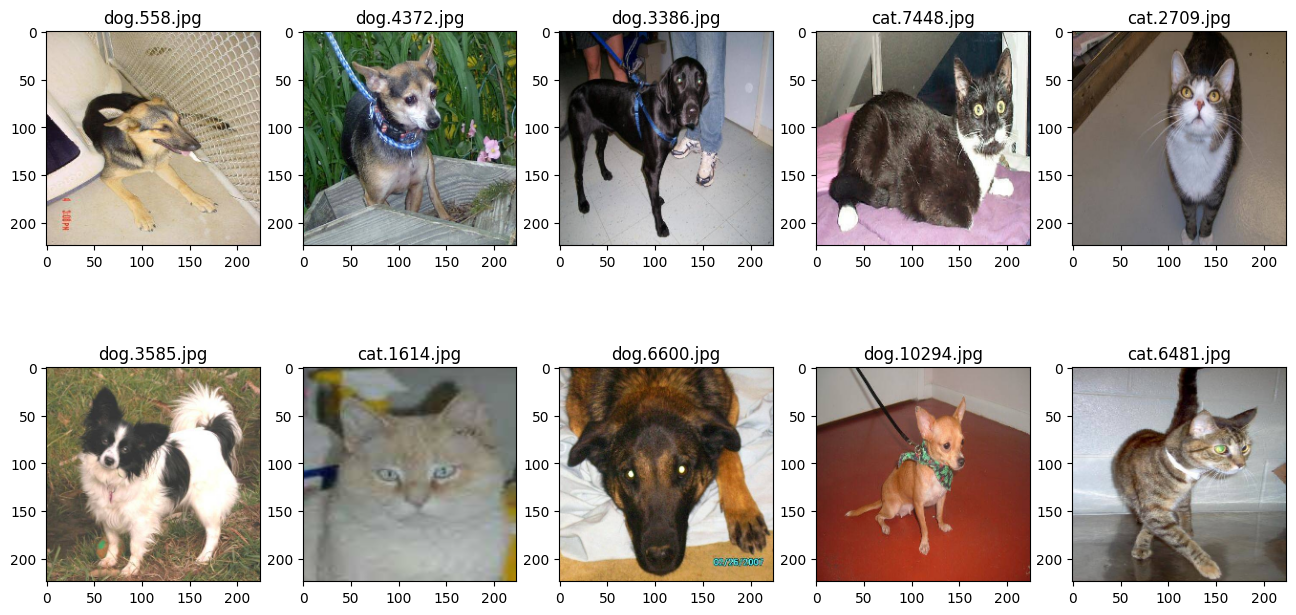

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

VGG16

In [ ]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [ ]:
train_data

<generator object fit_generator at 0x7ed2bc3aa730>

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid')(x)
#,  # функция активации
#                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
val_samples = 10  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=20,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/20
10/10 [==============================] - 238s 24s/step - loss: 196.2255 - accuracy: 0.6406 - val_loss: 49.2198 - val_accuracy: 0.9000
Epoch 2/20
10/10 [==============================] - 231s 23s/step - loss: 52.5636 - accuracy: 0.8156 - val_loss: 1.2150e-07 - val_accuracy: 1.0000
Epoch 3/20
10/10 [==============================] - 232s 23s/step - loss: 57.3303 - accuracy: 0.8656 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
 1/10 [==>...........................] - ETA: 4:25 - loss: 72.2584 - accuracy: 0.8125

In [ ]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

  150/12500 [..............................] - ETA: 2:20:14

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

NameError: name 'test_pred' is not defined

<Figure size 1600x800 with 0 Axes>

In [ ]:
import re

with open('./drive/MyDrive/ML/submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

<ipython-input-34-46bcc4871fc4>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))


MobileNetV2

In [19]:
from tensorflow.keras.preprocessing import image
import os
from random import shuffle
from glob import glob
from keras.applications.mobilenet import preprocess_input

# x=[] # array value of the images
# y=[] # the labels of the images

# image_list = os.listdir(train_dir)
# for img_name in image_list:
#     # Loading images
#     img = image.load_img(train_dir + img_name, target_size=(224,224))
#     img = image.img_to_array(img)

#     # Transfer Learning: Preprocess of MobileNetV2 model to our images before passing it to MobileNetV2
#     img = preprocess_input(img)

#     x.append(img) # appending image array
#     y.append(1. if img_name .startswith('dog') else 0. ) # appending class index to the array

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob(train_path)
test_files = glob(test_path)


# загружаем входное изображение и предобрабатываем
def load_image2(path, target_size=IMG_SIZE):
    img = image.load_img(path, target_size=(224,224))
    img = image.img_to_array(img)
    # Transfer Learning: Preprocess of MobileNetV2 model to our images before passing it to MobileNetV2
    return preprocess_input(img)

# функция-генератор загрузки обучающих данных с диска
def fit_generator2(files, batch_size=96): # batch_size=32
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image2(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(x , y, test_size=0.2, random_state=5)

In [24]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))

In [21]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [25]:
tf.keras.backend.clear_session()

model2 = Sequential([mnet,
                    # GlobalAveragePooling2D(),
                    # Dense(512, activation = "ReLU"),
                    # BatchNormalization(),
                    # Dropout(0.3),
                    #Dense(128, activation = "ReLU"),
                    #Dropout(0.1),
                    #Dense(32, activation = "ReLU"),
                    #Dropout(0.3),
                    Flatten(),
                    #Dense(32, activation = "ReLU"),
                    Dense(1, activation = "sigmoid")])

model2.layers[0].trainable = False

#model2.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")
#binary_crossentropy
model2.compile(loss="binary_crossentropy", optimizer="Adam", metrics="accuracy")

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1)                 62721     
                                                                 
Total params: 2320705 (8.85 MB)
Trainable params: 62721 (245.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
from random import shuffle

EPOCHS = 20

val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator2(train_files[:val_samples], val_samples))
train_data = fit_generator2(train_files[val_samples:])  # данные читаем функцией-генератором

# model2.fit(train_data,
#            epochs=20,  # число эпох обучения
#            callbacks=[lr_callbacks])
# запускаем процесс обучения
model2.fit(train_data,
           epochs=EPOCHS,  # число эпох обучения
           callbacks=[lr_callbacks],
           validation_data=validation_data )

#hist = model.fit(xtrain, ytrain, epochs=EPOCHS, callbacks=[lr_callbacks], validation_data=(xval,yval))

Epoch 1/20
   1067/Unknown - 5844s 5s/step - loss: 0.0038 - accuracy: 0.9989